# Moj rad

In [2]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD
from keras.models import model_from_json

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 8, 4 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

from pocetak import *
from services.preparation_for_neural_network import *
from services.show_result import *

In [3]:
# kreiranje recnika svih poznatih reci, za korekciju Levenstein rastojanjem
VOCABULARY_PATH = 'dataset/dict.txt'
vocabulary = dict()
with open(VOCABULARY_PATH, 'r', encoding='utf-8') as file:
    data = file.read()
    lines = data.split('\n')
    for index, line in enumerate(lines):
        cols = line.split()
        if len(cols) == 3:
            vocabulary[cols[1]] = cols[2]

duzina inputa: 60
duzina outputs: 60
Istrenirani model uspesno ucitan.


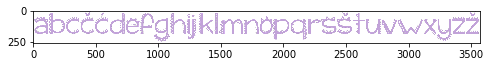

In [4]:
image_path0 = 'dataset/train/alphabet1.png'
letters0 = load_image_and_find_roi_HSV_TRAIN(image_path0)
alphabet0 = ['A', 'B', 'C', 'Č', 'Ć', 'D', 'E', 'F', 'G', 'H','I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S','Š', 'T', 'U','V', 'W', 'X', 'Y', 'Z', 'Ž']

image_path1 = 'dataset/train/alphabet1.png'
letters1 = load_image_and_find_roi_HSV_TRAIN(image_path1)
alphabet1 = ['a', 'b', 'c', 'č', 'ć', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q',
            'r', 's', 'š', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ž']
alphabet= alphabet0 + alphabet1
letters = letters0 + letters1

inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
print("duzina inputa: " + str(len(inputs)))
print("duzina outputs: " + str(len(outputs)))

# probaj da ucitas prethodno istreniran model
ann = load_trained_ann()

# ako je ann=None, znaci da model nije ucitan u prethodnoj metodi i da je potrebno istrenirati novu mrezu
if ann is None:
    print("Traniranje modela zapoceto.")
    ann = create_ann()
    ann = train_ann(ann, inputs, outputs)
    print("Treniranje modela zavrseno.")
    # serijalizuj novu mrezu nakon treniranja, da se ne trenira ponovo svaki put
    serialize_ann(ann)

In [ ]:
# Učitavanje slike i određivanje regiona od interesa
validation_image_path = 'dataset/train/alphabet1.png'
distances, letters = load_image_and_find_roi_HSV_validate(validation_image_path)

In [ ]:
# PREDIKCIJA
print(extract_text(distances, letters, ann,vocabulary))

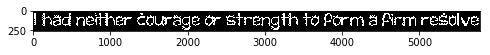

In [166]:
# POPRAVLJANJEEEE SEGMENTACIJE
image_path = 'dataset/validation/train0.png'

img = cv2.imread(image_path)
image = img.copy()
best_channel = image[:, :, 1]
ret, image_bin = cv2.threshold(best_channel, 0, 255, cv2.THRESH_OTSU)
invertovana = invert(image_bin)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(invertovana, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(opening,'gray')

In [167]:
# ISPRAVLJANJE SLIKE
coords = np.column_stack(np.where(opening>0))
angle = cv2.minAreaRect(coords)[-1]

# print("ugao: " + str(angle))
if angle < - 45:
    angle = - (90 + angle)
else:
    angle = -angle
print(angle)

-0.0146636962890625


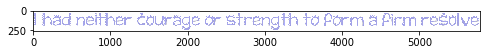

In [168]:
(h, w) = image.shape[:2]
center = (w//2,h//2)
M = cv2.getRotationMatrix2D(center,angle,1.0)
rotirana = cv2.warpAffine(image,M,(w,h),flags=cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)
plt.imshow(rotirana,'gray')

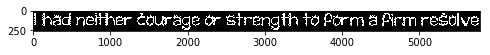

In [169]:
img = rotirana
image = img.copy()
best_channel = image[:, :, 1]
ret, image_bin = cv2.threshold(best_channel, 0, 255, cv2.THRESH_OTSU)
invertovana = invert(image_bin)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(invertovana, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(opening,'gray')

pronadjeno kontura: 162
meni koristnih: 46


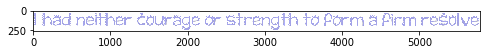

In [170]:
imga, contours, hierarchy = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_crtanje = img.copy()
regions_array = []
print("pronadjeno kontura: " + str(len(contours)))
regija_kvacica = []

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# TODO: PORAVNATI CELU SLIKU NEKAKO
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    k = y - 20
    if k < 1:
        k = y
    region = opening[k:y + h + 1, x:x + w + 1]
    if w < 10 or h < 45 or (h + w) < 50: 
#         print("\t\t\th: " + str(h) + " w: " + str(w) + " size: " + str(h + w))
        continue
    # ZA SVAKI REGION RADIM POBOLJSANJE
    region = cv2.morphologyEx(region.copy(), cv2.MORPH_DILATE, kernel, iterations=3)

    regions_array.append([region, (x, y, w, h)])
    
    
plt.imshow(image_crtanje)

regions_array = sorted(regions_array, key=lambda item: item[1][0])
sorted_regions = [region[0] for region in regions_array]
sorted_rectangles = [region[1] for region in regions_array]
    

region_distances = []
# Izdvojiti sortirane parametre opisujućih pravougaonika
# Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
for index in range(0, len(sorted_rectangles) - 1):    
    current = sorted_rectangles[index]
    next_rect = sorted_rectangles[index + 1]    
    distance = next_rect[0] - (current[0] + current[2])  # X_next - (X_current + W_current)
    region_distances.append(distance)


print("meni koristnih: " + str(len(sorted_regions)))


In [102]:
# PREDIKCIJA
print(extract_text(region_distances, sorted_regions, ann,vocabulary))

		 recenica: abcčćdefghij kl mnopqrsštuvwxyzž
		 procesirana recenica: ačćidental keenly opprešt

ačćidental keenly opprešt


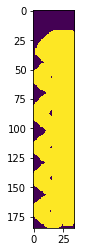

In [171]:
plt.imshow(sorted_regions[0])

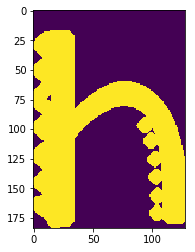

In [172]:
plt.imshow(sorted_regions[1])

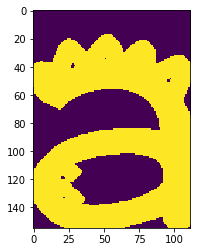

In [173]:
plt.imshow(sorted_regions[2])

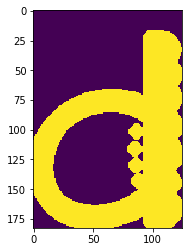

In [174]:
plt.imshow(sorted_regions[3])

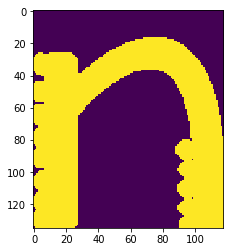

In [175]:
plt.imshow(sorted_regions[4])

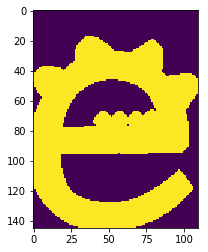

In [176]:
plt.imshow(sorted_regions[5])

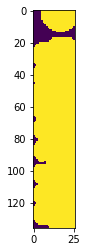

In [177]:
plt.imshow(sorted_regions[6])

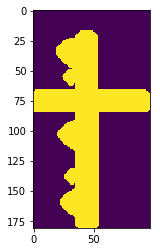

In [178]:
plt.imshow(sorted_regions[7])

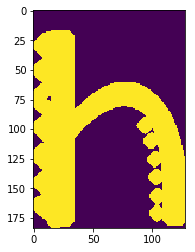

In [179]:
plt.imshow(sorted_regions[8])

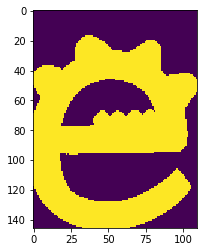

In [180]:
plt.imshow(sorted_regions[9])

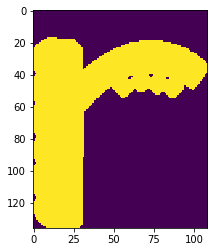

In [181]:
plt.imshow(sorted_regions[10])

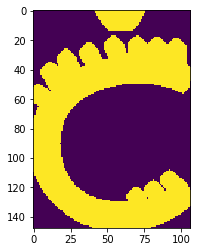

In [182]:
plt.imshow(sorted_regions[11])

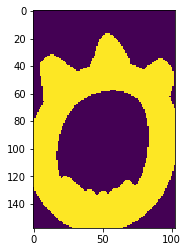

In [183]:
plt.imshow(sorted_regions[12])

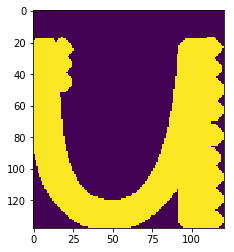

In [184]:
plt.imshow(sorted_regions[13])

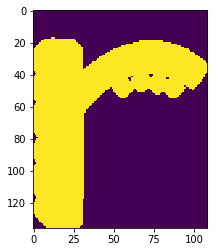

In [185]:
plt.imshow(sorted_regions[14])

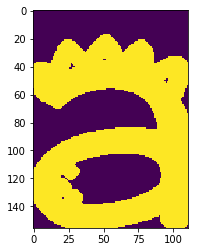

In [186]:
plt.imshow(sorted_regions[15])

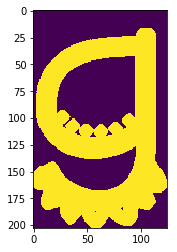

In [187]:
plt.imshow(sorted_regions[16])

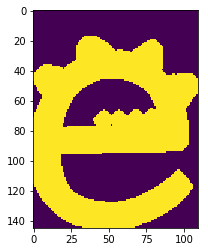

In [188]:
plt.imshow(sorted_regions[17])

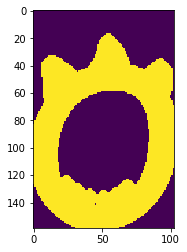

In [189]:
plt.imshow(sorted_regions[18])

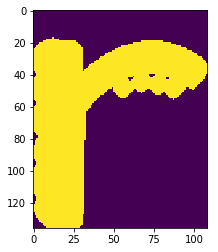

In [190]:
plt.imshow(sorted_regions[19])

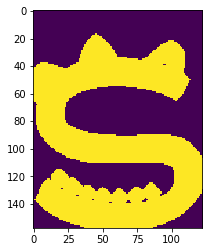

In [191]:
plt.imshow(sorted_regions[20])

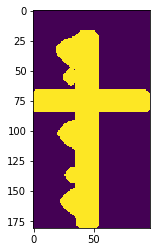

In [192]:
plt.imshow(sorted_regions[21])

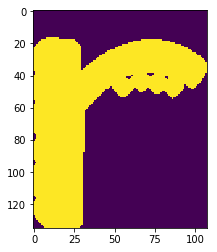

In [193]:
plt.imshow(sorted_regions[22])

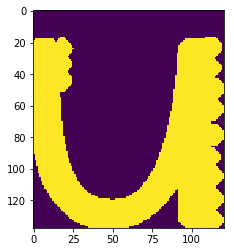

In [159]:
plt.imshow(sorted_regions[23])

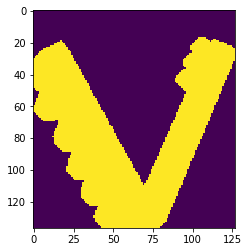

In [160]:
plt.imshow(sorted_regions[24])

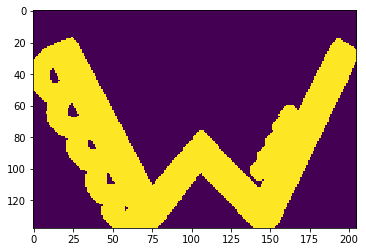

In [161]:
plt.imshow(sorted_regions[25])

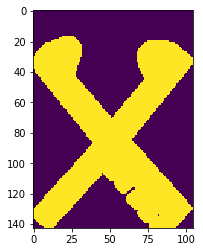

In [162]:
plt.imshow(sorted_regions[26])

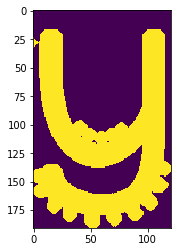

In [163]:
plt.imshow(sorted_regions[27])

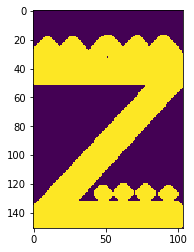

In [164]:
plt.imshow(sorted_regions[28])

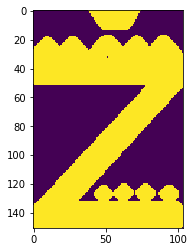

In [165]:
plt.imshow(sorted_regions[29])

In [ ]:
plt.imshow(sorted_regions[30])

In [ ]:
plt.imshow(sorted_regions[31])

In [ ]:
plt.imshow(sorted_regions[32])

In [ ]:
plt.imshow(sorted_regions[33])

In [ ]:
plt.imshow(sorted_regions[34])

In [ ]:
plt.imshow(sorted_regions[35])